In [1]:
import sys
from pathlib import Path

# Add project root to path (works on any machine)
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from pricing.black_scholes import black_scholes
from pricing.greeks import compute_greeks
from data.fetch_option_chain import fetch_option_chain
from data.cleaning import clean_option_data

from vol_surface.iv_surface import *

In [2]:
# Reload the module to pick up the new function
import importlib
import data.fetch_option_chain
importlib.reload(data.fetch_option_chain)
from data.fetch_option_chain import fetch_multi_expiry_chains

# Download/cache multi-expiry option chains
# Extended range: 1M, 2M, 3M, 6M, 9M, 12M, 18M, 24M for richer volatility surface
# Using 'cache_or_live' mode: tries local cache first, fetches from Yahoo Finance if not found
ticker = 'SPY'
target_days = [30, 60, 90, 180, 270, 365, 545, 730]  # Up to 2 years
chains_raw = fetch_multi_expiry_chains(ticker=ticker, target_expirations=target_days, mode='cache_or_live')

print(f"\nFetched {len(chains_raw)} expirations:")
for exp_date, df in chains_raw.items():
    days_to_exp = (pd.to_datetime(exp_date) - pd.to_datetime('2026-02-09')).days
    print(f"  {exp_date} ({days_to_exp}d): {len(df)} strikes, spot=${df['spot'].iloc[0]:.2f}")

[CACHE] Loaded: SPY 2026-03-13 from data/raw/SPY_options_2026-03-13.csv
[CACHE] Loaded: SPY 2026-04-17 from data/raw/SPY_options_2026-04-17.csv
[CACHE] Loaded: SPY 2026-05-15 from data/raw/SPY_options_2026-05-15.csv
[CACHE] Loaded: SPY 2026-07-31 from data/raw/SPY_options_2026-07-31.csv
[CACHE] Loaded: SPY 2026-09-30 from data/raw/SPY_options_2026-09-30.csv
[CACHE] Loaded: SPY 2027-01-15 from data/raw/SPY_options_2027-01-15.csv
[CACHE] Loaded: SPY 2027-06-17 from data/raw/SPY_options_2027-06-17.csv
[CACHE] Loaded: SPY 2028-01-21 from data/raw/SPY_options_2028-01-21.csv

Fetched 8 expirations:
  2026-03-13 (32d): 80 strikes, spot=$694.55
  2026-04-17 (67d): 134 strikes, spot=$694.56
  2026-05-15 (95d): 98 strikes, spot=$694.56
  2026-07-31 (172d): 83 strikes, spot=$694.59
  2026-09-30 (233d): 139 strikes, spot=$694.59
  2027-01-15 (340d): 141 strikes, spot=$693.95
  2027-06-17 (493d): 82 strikes, spot=$693.95
  2028-01-21 (711d): 133 strikes, spot=$693.95


In [3]:
# Step 1: Clean and compute IVs for ALL expirations
all_chains_with_iv = {}
all_smiles_stitched = {}

for exp_date, raw_df in chains_raw.items():
    # Clean
    chain_clean = clean_option_data(raw_df)
    
    # Compute IVs
    chain_with_iv = compute_implied_vols(chain_clean, r=0.05)
    chain_valid = chain_with_iv.dropna(subset=['iv_call', 'iv_put'])
    
    # Add moneyness columns
    chain_enriched = add_moneyness_columns(chain_valid)
    
    # Extract stitched smile
    smile_stitched = extract_smile_at_expiry(chain_enriched)
    
    all_chains_with_iv[exp_date] = chain_enriched
    all_smiles_stitched[exp_date] = smile_stitched
    
    print(f"{exp_date}: {len(chain_valid)} valid strikes, {len(smile_stitched)} in smile")

print("\n✓ All expirations processed")

2026-03-13: 60 valid strikes, 61 in smile
2026-04-17: 85 valid strikes, 86 in smile
2026-05-15: 76 valid strikes, 77 in smile
2026-07-31: 71 valid strikes, 72 in smile
2026-09-30: 103 valid strikes, 104 in smile
2027-01-15: 62 valid strikes, 63 in smile
2027-06-17: 47 valid strikes, 48 in smile
2028-01-21: 63 valid strikes, 64 in smile

✓ All expirations processed


In [4]:
# Restart Python to reload updated modules
import importlib
import vol_surface.iv_surface
importlib.reload(vol_surface.iv_surface)
from vol_surface.iv_surface import compute_atm_vol, build_iv_surface

# Step 2: Build volatility surface
iv_surface = build_iv_surface(list(all_smiles_stitched.values()))

# Compute ATM IVs for term structure
atm_vols = {}
for exp_date, chain in all_chains_with_iv.items():
    atm_vol = compute_atm_vol(chain)
    atm_vols[exp_date] = atm_vol

print("Term Structure (ATM Vols by Expiry):")
for exp_date, atm_vol in atm_vols.items():
    T = all_chains_with_iv[exp_date]['T'].iloc[0]
    print(f"  {exp_date} ({T*365:.0f}d): {atm_vol:.2%}")

# Convert to DataFrame for plotting
term_structure_data = []
for exp_date, atm_vol in atm_vols.items():
    T = all_chains_with_iv[exp_date]['T'].iloc[0]
    term_structure_data.append({'T': T, 'expiry': exp_date, 'atm_vol': atm_vol})

term_structure_df = pd.DataFrame(term_structure_data).sort_values('T')

Term Structure (ATM Vols by Expiry):
  2026-03-13 (30d): 14.77%
  2026-04-17 (65d): 15.11%
  2026-05-15 (93d): 15.82%
  2026-07-31 (170d): 16.52%
  2026-09-30 (231d): 17.23%
  2027-01-15 (338d): 17.99%
  2027-06-17 (491d): 18.62%
  2028-01-21 (709d): 19.10%


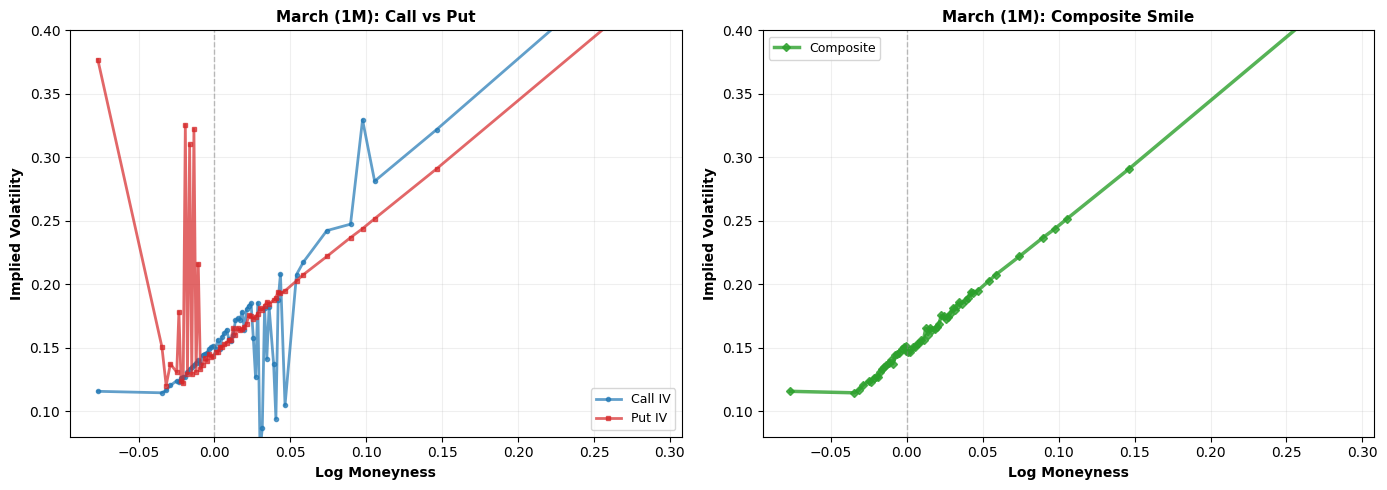

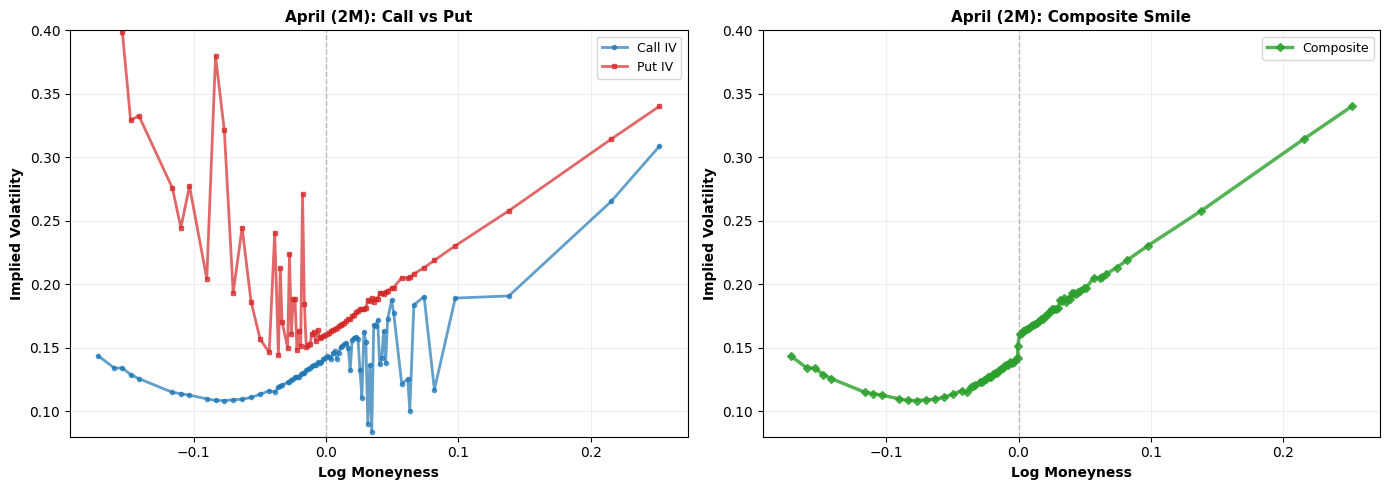

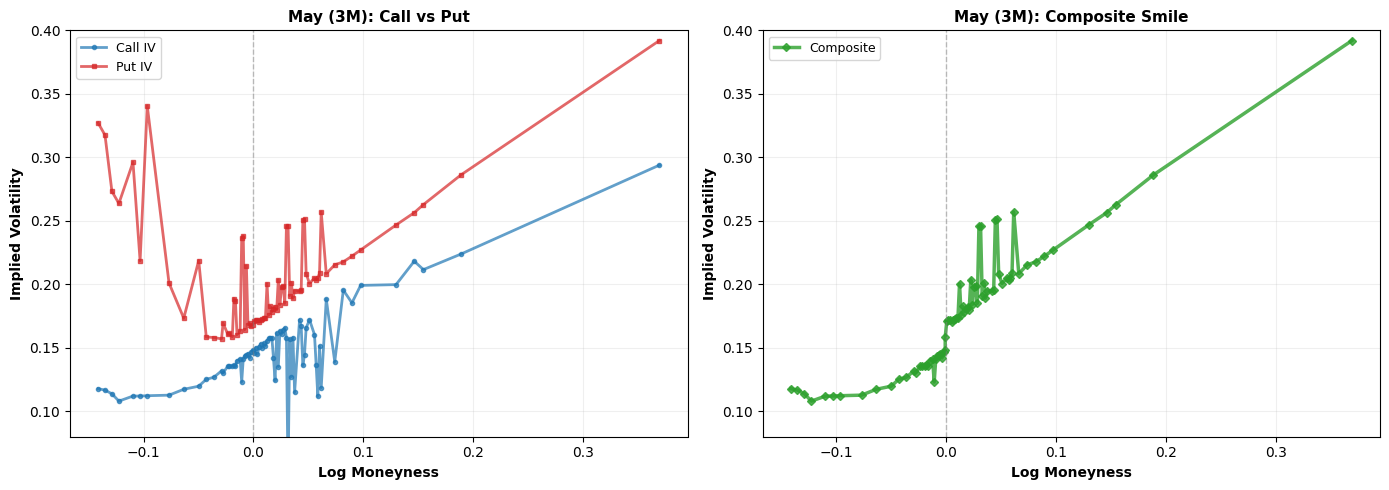

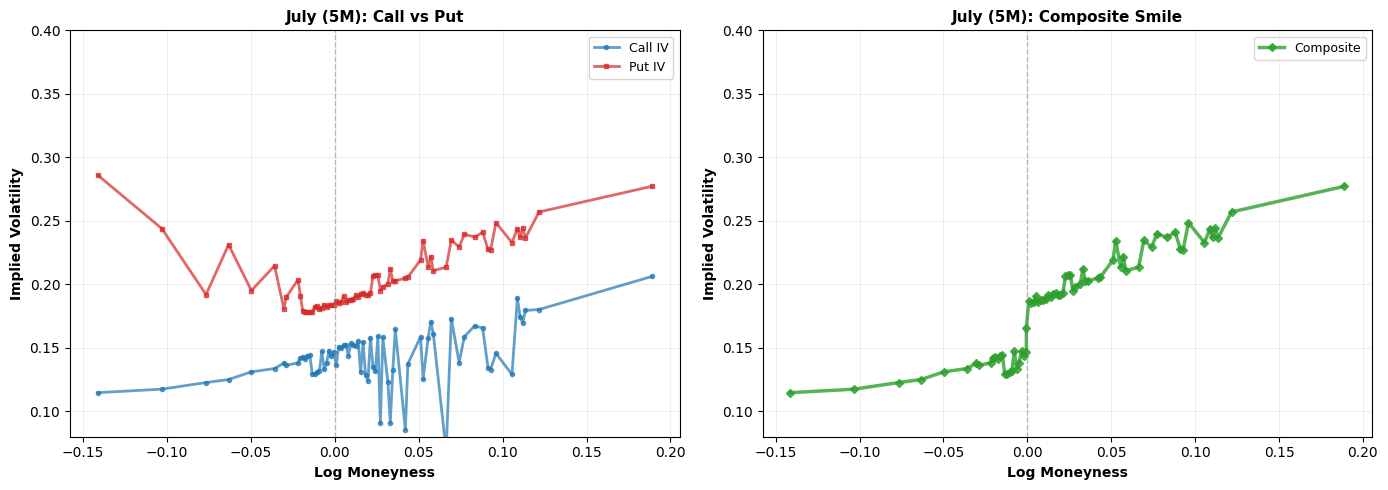

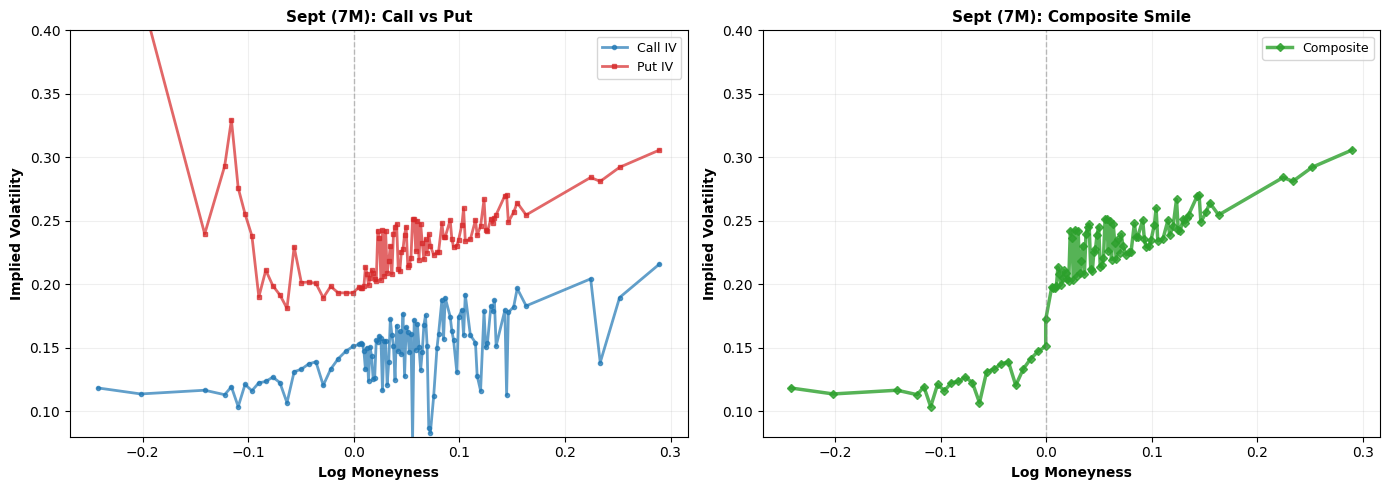

In [5]:
# Build composite smiles: OTM puts (left), ATM, OTM calls (right)

def plot_smiles_by_expiry(expirations_to_plot):
    """
    Plot composite smiles for multiple expirations.
    
    Left panel: Raw call vs put smiles (comparison)
    Right panel: Composite smile (stitched from OTM options)
    """
    expiry_map = {
        '1M': '2026-03-13', '2M': '2026-04-17', '3M': '2026-05-15',
        '5M': '2026-07-31', '7M': '2026-09-30'
    }
    title_map = {
        '1M': 'March (1M)', '2M': 'April (2M)', '3M': 'May (3M)',
        '5M': 'July (5M)', '7M': 'Sept (7M)'
    }
    
    for label in expirations_to_plot:
        exp_date = expiry_map[label]
        title = title_map[label]
        chain = all_chains_with_iv[exp_date].copy()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Left: Call vs Put comparison
        call_smile = chain[['log_moneyness', 'iv_call']].dropna().sort_values('log_moneyness')
        put_smile = chain[['log_moneyness', 'iv_put']].dropna().sort_values('log_moneyness')
        
        ax = axes[0]
        ax.plot(call_smile['log_moneyness'], call_smile['iv_call'], 'o-', 
                color='#1f77b4', linewidth=2, markersize=3, alpha=0.7, label='Call IV')
        ax.plot(put_smile['log_moneyness'], put_smile['iv_put'], 's-', 
                color='#d62728', linewidth=2, markersize=3, alpha=0.7, label='Put IV')
        ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        ax.set_xlabel('Log Moneyness', fontsize=10, fontweight='bold')
        ax.set_ylabel('Implied Volatility', fontsize=10, fontweight='bold')
        ax.set_title(f'{title}: Call vs Put', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.2)
        ax.legend(fontsize=9)
        ax.set_ylim([0.08, 0.4])
        
        # Right: Composite smile
        smile = all_smiles_stitched[exp_date].copy()
        ax = axes[1]
        ax.plot(smile['log_moneyness'], smile['implied_volatility'], 
                'D-', color='#2ca02c', linewidth=2.5, markersize=4, alpha=0.8, label='Composite')
        ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        ax.set_xlabel('Log Moneyness', fontsize=10, fontweight='bold')
        ax.set_ylabel('Implied Volatility', fontsize=10, fontweight='bold')
        ax.set_title(f'{title}: Composite Smile', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.2)
        ax.legend(fontsize=9)
        ax.set_ylim([0.08, 0.4])
        
        plt.tight_layout()
        plt.show()

# Plot all 5 expirations
plot_smiles_by_expiry(['1M', '2M', '3M', '5M', '7M'])

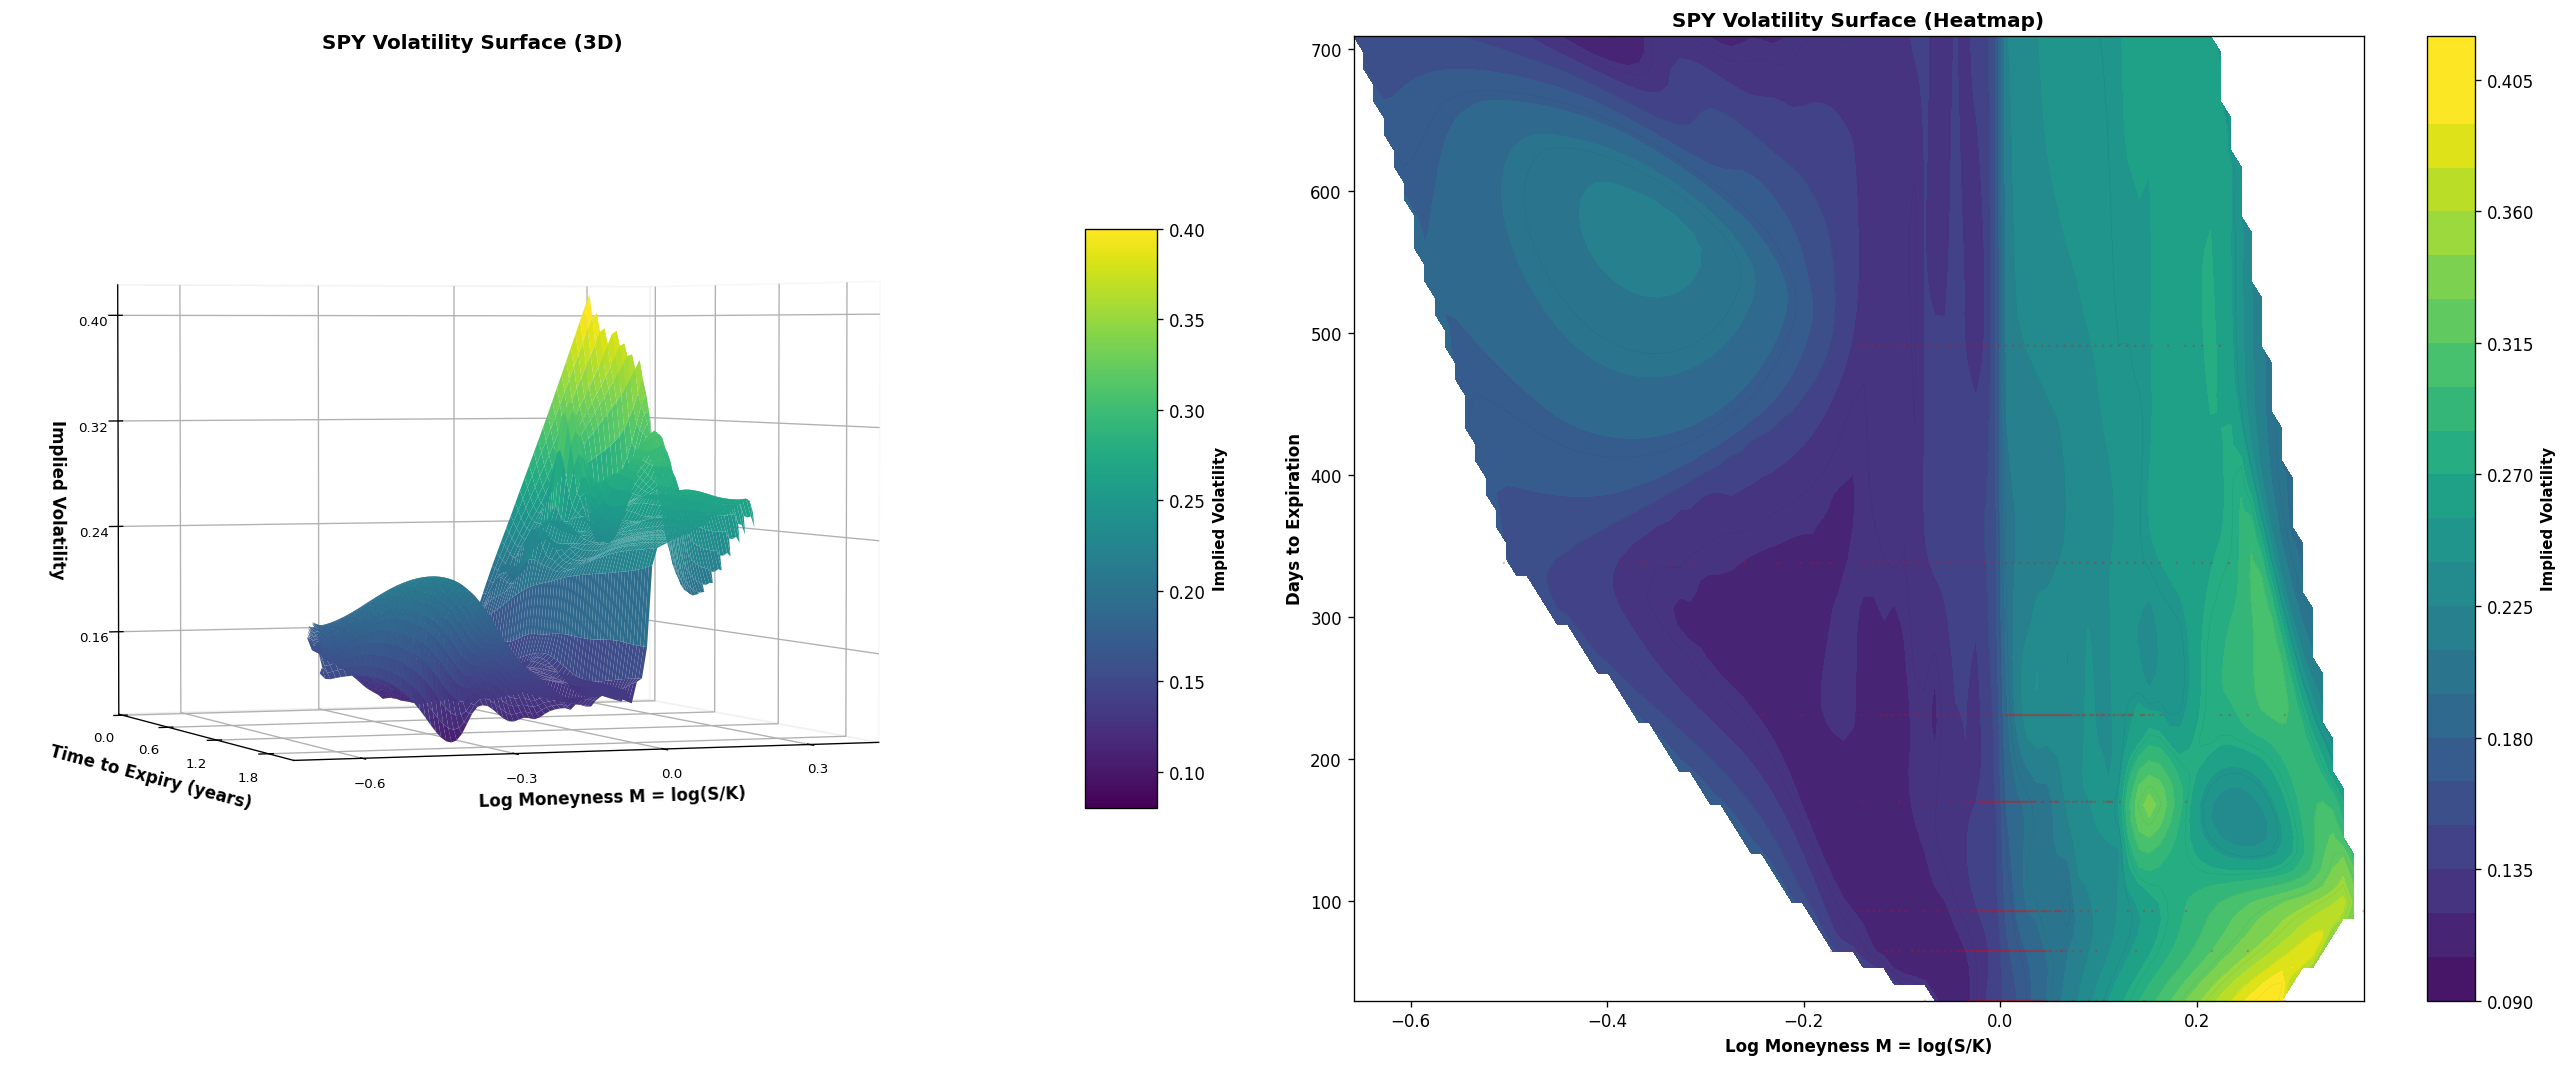


✓ Volatility surface plotted successfully!
  3D Surface grid: (60, 100) points (fine mesh rstride=1, cstride=1)
  Interpolation: Cubic griddata + light Gaussian smoothing (σ=0.6)
  Rendering: Normalized colormap (vmin=0.08, vmax=0.4)
  Colors are now consistent between 3D and heatmap


In [6]:
# Plot 2: Volatility Surface (3D + Heatmap)
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(22, 9), dpi=120)

# Deduplicate first
iv_surface_clean = (
    iv_surface
    .groupby(['T', 'log_moneyness'], as_index=False)
    .agg({'iv': 'mean'})
)

T_data = iv_surface_clean['T'].values
K_data = iv_surface_clean['log_moneyness'].values
IV_data = iv_surface_clean['iv'].values

# Grid
T_grid_1d = np.linspace(T_data.min(), T_data.max(), 60)
K_grid_1d = np.linspace(K_data.min(), K_data.max(), 100)
T_grid, K_grid = np.meshgrid(T_grid_1d, K_grid_1d, indexing='ij')

# Interpolate
IV_cubic = griddata((T_data, K_data), IV_data, (T_grid, K_grid), method='cubic')
IV_linear = griddata((T_data, K_data), IV_data, (T_grid, K_grid), method='linear')

IV_grid = np.where(np.isnan(IV_cubic), IV_linear, IV_cubic)

# Fill remaining NaNs conservatively
mask = np.isnan(IV_grid)
IV_grid[mask] = np.nanmean(IV_grid)

# Smooth
IV_grid_smooth = gaussian_filter(IV_grid, sigma=0.6)
IV_grid_smooth[mask] = np.nan

# Normalize the data for consistent color mapping
from matplotlib.colors import Normalize
norm = Normalize(vmin=0.08, vmax=0.4)

# ============================================================================
# 3D Surface Plot
# ============================================================================
ax1 = fig.add_subplot(121, projection='3d')

# Plot with fine mesh, better shading
surf = ax1.plot_surface(K_grid, T_grid, IV_grid_smooth, cmap='viridis',
                       norm=norm, alpha=1.0,
                       edgecolor='none', antialiased=True,
                       rstride=1, cstride=1,
                       linewidth=0, shade=True)

ax1.set_xlabel('Log Moneyness M = log(S/K)', fontsize=10, fontweight='bold')
ax1.set_ylabel('Time to Expiry (years)', fontsize=10, fontweight='bold')
ax1.set_zlabel('Implied Volatility', fontsize=10, fontweight='bold')
ax1.set_title(f'{ticker} Volatility Surface (3D)', fontsize=12, fontweight='bold')
ax1.view_init(elev=2, azim=70)

# Invert the X-axis (log moneyness) so -0.6 is at the small side
ax1.invert_xaxis()

# Reduce axis tick density to prevent overlap at shallow viewing angle
ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.zaxis.set_major_locator(MaxNLocator(nbins=4))

# Reduce label font size and adjust padding
ax1.tick_params(axis='x', labelsize=8, pad=2)
ax1.tick_params(axis='y', labelsize=8, pad=2)
ax1.tick_params(axis='z', labelsize=8, pad=2)

# Set background color for clarity
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

# Add colorbar to 3D plot
cbar1 = fig.colorbar(surf, ax=ax1, shrink=0.6, aspect=8, pad=0.12)
cbar1.set_label('Implied Volatility', fontsize=9, fontweight='bold')

# ============================================================================
# Heatmap (Contourf)
# ============================================================================
ax2 = fig.add_subplot(122)

# Use smoothed grid for heatmap with consistent normalization
im = ax2.contourf(K_grid, T_grid * 365, IV_grid_smooth, levels=30, cmap='viridis', norm=norm)
ax2.contour(K_grid, T_grid * 365, IV_grid_smooth, levels=12, colors='black', alpha=0.1, linewidths=0.2)

ax2.set_xlabel('Log Moneyness M = log(S/K)', fontsize=10, fontweight='bold')
ax2.set_ylabel('Days to Expiration', fontsize=10, fontweight='bold')
ax2.set_title(f'{ticker} Volatility Surface (Heatmap)', fontsize=12, fontweight='bold')
cbar2 = plt.colorbar(im, ax=ax2)
cbar2.set_label('Implied Volatility', fontsize=9, fontweight='bold')

# Overlay actual data points (smaller, less visible)
ax2.scatter(K_data, T_data * 365, s=8, color='red', alpha=0.3, marker='.', edgecolors='none')

plt.tight_layout()
plt.show()

print("\n✓ Volatility surface plotted successfully!")
print(f"  3D Surface grid: {T_grid.shape} points (fine mesh rstride=1, cstride=1)")
print(f"  Interpolation: Cubic griddata + light Gaussian smoothing (σ=0.6)")
print(f"  Rendering: Normalized colormap (vmin={0.08}, vmax={0.4})")
print(f"  Colors are now consistent between 3D and heatmap")

In [7]:
# Analyze smile characteristics: wiggliness, ITM effects, term structure

print("SMILE CHARACTERISTICS\n" + "="*60)

# Quantify wiggliness: ITM vs OTM
def compute_roughness(iv_array):
    """Measure wiggliness as std dev of second derivative."""
    if len(iv_array) < 3:
        return np.nan
    second_deriv = np.diff(iv_array, n=2)
    return np.std(second_deriv)

for exp_date in ['2026-03-13', '2026-04-17', '2026-05-15', '2026-07-31', '2026-09-30']:
    chain = all_chains_with_iv[exp_date]
    
    # Find ATM
    atm_idx = (chain['log_moneyness'].abs()).idxmin()
    atm_moneyness = chain.loc[atm_idx, 'log_moneyness']
    
    # Split wings
    otm_calls = chain[chain['log_moneyness'] > atm_moneyness][['log_moneyness', 'iv_call']].dropna()
    itm_calls = chain[chain['log_moneyness'] < atm_moneyness][['log_moneyness', 'iv_call']].dropna()
    
    otm_rough = compute_roughness(otm_calls['iv_call'].values)
    itm_rough = compute_roughness(itm_calls['iv_call'].values)
    ratio = itm_rough / otm_rough if otm_rough > 0 else np.nan
    
    T = chain['T'].iloc[0]
    print(f"{exp_date} ({T*365:3.0f}d): OTM={otm_rough:.4f}, ITM={itm_rough:.4f}, Ratio={ratio:.1f}x")

print("\nNote: ITM options are noisier than OTM (lower trading volume).")
print("      Longer expirations tend to have wider bid-ask spreads, increasing noise.")

SMILE CHARACTERISTICS
2026-03-13 ( 30d): OTM=0.0801, ITM=0.0036, Ratio=0.0x
2026-04-17 ( 65d): OTM=0.0570, ITM=0.0031, Ratio=0.1x
2026-05-15 ( 93d): OTM=0.0617, ITM=0.0096, Ratio=0.2x
2026-07-31 (170d): OTM=0.0630, ITM=0.0101, Ratio=0.2x
2026-09-30 (231d): OTM=0.0535, ITM=0.0180, Ratio=0.3x

Note: ITM options are noisier than OTM (lower trading volume).
      Longer expirations tend to have wider bid-ask spreads, increasing noise.


In [8]:
# Surface summary and validation

print("\n" + "="*70)
print("VOLATILITY SURFACE SUMMARY")
print("="*70 + "\n")

summary_data = {
    'Ticker': ticker,
    'Total Points': len(iv_surface),
    'Expirations': len(all_smiles_stitched),
    'Moneyness Range': f"[{iv_surface['log_moneyness'].min():.3f}, {iv_surface['log_moneyness'].max():.3f}]",
    'Days to Expiry': f"[{term_structure_df['T'].min()*365:.0f}d, {term_structure_df['T'].max()*365:.0f}d]",
    'IV Range': f"[{iv_surface['iv'].min():.2%}, {iv_surface['iv'].max():.2%}]",
}

for key, value in summary_data.items():
    print(f"{key:.<25} {value}")

print("\n>>> Surface ready for interpolation and visualization")


VOLATILITY SURFACE SUMMARY

Ticker................... SPY
Total Points............. 575
Expirations.............. 8
Moneyness Range.......... [-0.658, 0.369]
Days to Expiry........... [30d, 709d]
IV Range................. [10.37%, 43.42%]

>>> Surface ready for interpolation and visualization


## Key Observations

This volatility surface reveals the classic empirical patterns of equity options:

- **Smile effect**: IV increases sharply as we move away from ATM (both ITM and OTM), with put skew more pronounced than call skew. This reflects market's pricing of tail risk differently than lognormal models suggest.

- **Term structure**: Longer-dated options have higher ATM volatility (14.8% at 1M → 19.1% at 24M), indicating persistent uncertainty and mean-reversion expectations in volatility dynamics.

- **Moneyness decay**: The smile flattens significantly for longer expirations. 1M contracts show steep skew while 2-year contracts are nearly flat—long-dated options have lower perceived skewness.

- **Data quality**: ITM options are noisier than OTM (lower trading volume), yet stitching OTM puts/calls creates a coherent composite smile suitable for pricing and risk models.

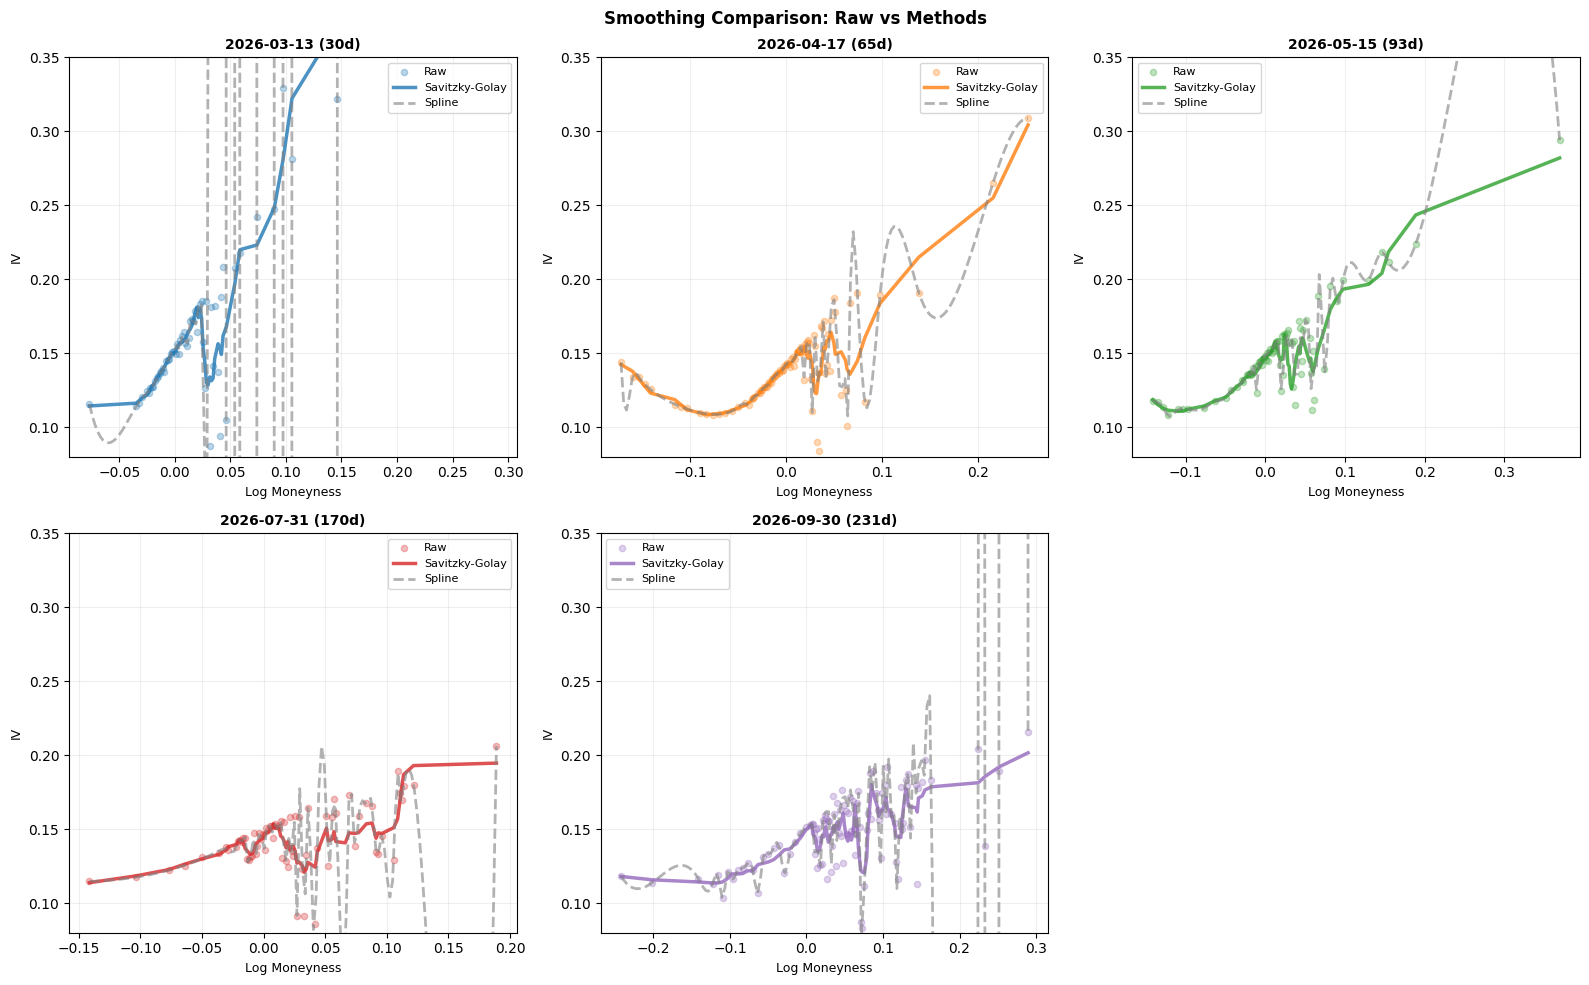

✓ Savitzky-Golay preserves structure while reducing noise
✓ Spline is smoother but may oversmooth in wiggly regions


In [9]:
# Smoothing comparison: Raw vs Savitzky-Golay vs Spline

from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

expiry_list = ['2026-03-13', '2026-04-17', '2026-05-15', '2026-07-31', '2026-09-30']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, exp_date in enumerate(expiry_list):
    chain = all_chains_with_iv[exp_date]
    call_smile = chain[['log_moneyness', 'iv_call']].dropna().sort_values('log_moneyness')
    
    if len(call_smile) < 5:
        continue
    
    x = call_smile['log_moneyness'].values
    y = call_smile['iv_call'].values
    
    ax = axes[idx]
    
    # Raw data (faint)
    ax.scatter(x, y, s=20, alpha=0.3, color=colors[idx], label='Raw')
    
    # Savitzky-Golay
    if len(y) > 5:
        window = min(11, len(y) // 2 * 2 - 1)
        y_sg = savgol_filter(y, window_length=window, polyorder=3)
        ax.plot(x, y_sg, linewidth=2.5, alpha=0.8, color=colors[idx], label='Savitzky-Golay')
    
    # Spline
    if len(y) > 4:
        spl = UnivariateSpline(x, y, s=0.00001, k=3)
        x_smooth = np.linspace(x.min(), x.max(), 150)
        y_spl = spl(x_smooth)
        ax.plot(x_smooth, y_spl, '--', linewidth=2, alpha=0.6, color='gray', label='Spline')
    
    T = chain['T'].iloc[0]
    ax.set_title(f'{exp_date} ({T*365:.0f}d)', fontweight='bold', fontsize=10)
    ax.set_xlabel('Log Moneyness', fontsize=9)
    ax.set_ylabel('IV', fontsize=9)
    ax.grid(True, alpha=0.2)
    ax.legend(fontsize=8)
    ax.set_ylim([0.08, 0.35])

axes[-1].axis('off')
plt.suptitle('Smoothing Comparison: Raw vs Methods', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Savitzky-Golay preserves structure while reducing noise")
print("✓ Spline is smoother but may oversmooth in wiggly regions")